## Stateful Basic Model Feedback Metrics 

We will be able to see real time metrics for ml metrics as follows:

![](img/realtime-accuracy.jpg)

At the end we will be able to compare two models performance against each other.

The screenshot below shows the shadow and default model performance.

![](img/comparison.jpg)

This will explore two architecture to achieve this, namely:
* Through a separate stateful metrics server using knative eventing (left)
* Through the model server leveraging custom metrics (right)

<table>
<tr>
<td>
    <img src="img/custom-stateful.jpg">
</td>
<td>
    <img src="img/standard-server.jpg">
</td>
</tr>
</table>

### Setup dependencies
* Istio
* Seldon Core (with Istio + Req Logger)
* Elasticsearch
* Knative eventing
* Request logger
* Model with request logger

#### Istio

In [4]:
!istioctl install -y

Detected that your cluster does not support third party JWT authentication. Falling back to less secure first party JWT. See https://istio.io/docs/ops/best-practices/security/#configure-third-party-service-account-tokens for details.
✔ Istio core installed                                                          
✔ Istiod installed                                                              
✔ Addons installed                                                              
✔ Ingress gateways installed                                                    
✔ Installation complete                                                         

In [3]:
%%bash
kubectl apply -n istio-system -f - << END
apiVersion: networking.istio.io/v1alpha3
kind: Gateway
metadata:
  name: seldon-gateway
spec:
  selector:
    istio: ingressgateway # use istio default controller
  servers:
  - port:
      number: 80
      name: http
      protocol: HTTP
    hosts:
    - "*"
END

gateway.networking.istio.io/seldon-gateway created


#### Seldon Core

In [36]:
%%bash
kubectl create ns seldon-system || echo "seldon-system ns exists"

helm upgrade --install seldon-core ../../../helm-charts/seldon-core-operator/ \
    --namespace seldon-system \
    --set certmanager.enabled="true" \
    --set istio.enabled="true" \
    --set istio.gateway="seldon-gateway.istio-system.svc.cluster.local" \
    --set executor.requestLogger.defaultEndpoint="http://default-broker.seldon-logs.svc.cluster.local"

seldon-system ns exists
Release "seldon-core" does not exist. Installing it now.
NAME: seldon-core
LAST DEPLOYED: Sat Jul 11 09:24:28 2020
NAMESPACE: seldon-system
STATUS: deployed
REVISION: 1
TEST SUITE: None


Error from server (AlreadyExists): namespaces "seldon-system" already exists


In [7]:
%%bash
kubectl create ns seldon-logs || echo "seldon-logs ns exists"
helm upgrade --install elasticsearch elasticsearch \
    --version 7.6.0 \
    --namespace=seldon-logs \
    --set service.type=LoadBalancer \
    --set antiAffinity="soft" \
    --repo https://helm.elastic.co \
    --set image=docker.elastic.co/elasticsearch/elasticsearch-oss

namespace/seldon-logs created
Release "elasticsearch" does not exist. Installing it now.
NAME: elasticsearch
LAST DEPLOYED: Sat Jul 11 08:56:31 2020
NAMESPACE: seldon-logs
STATUS: deployed
REVISION: 1
NOTES:
1. Watch all cluster members come up.
  $ kubectl get pods --namespace=seldon-logs -l app=elasticsearch-master -w
2. Test cluster health using Helm test.
  $ helm test elasticsearch


In [9]:
!kubectl rollout status statefulset/elasticsearch-master -n seldon-logs

Waiting for 3 pods to be ready...
Waiting for 2 pods to be ready...
Waiting for 1 pods to be ready...
statefulset rolling update complete 3 pods at revision elasticsearch-master-695c796997...


#### Knative Eventing

In [29]:
%%bash

kubectl apply --selector knative.dev/crd-install=true \
	--filename https://github.com/knative/eventing/releases/download/v0.11.0/eventing.yaml

kubectl apply --selector knative.dev/crd-install=true \
	--filename https://github.com/knative/eventing/releases/download/v0.11.0/eventing.yaml 

kubectl apply \
	--filename https://github.com/knative/eventing/releases/download/v0.11.0/eventing.yaml 

kubectl rollout status -n knative-eventing deployment/eventing-controller

kubectl apply --filename https://github.com/knative/eventing/releases/download/v0.11.0/in-memory-channel.yaml

customresourcedefinition.apiextensions.k8s.io/apiserversources.sources.eventing.knative.dev created
customresourcedefinition.apiextensions.k8s.io/brokers.eventing.knative.dev created
customresourcedefinition.apiextensions.k8s.io/channels.messaging.knative.dev created
customresourcedefinition.apiextensions.k8s.io/containersources.sources.eventing.knative.dev created
customresourcedefinition.apiextensions.k8s.io/cronjobsources.sources.eventing.knative.dev created
customresourcedefinition.apiextensions.k8s.io/eventtypes.eventing.knative.dev created
customresourcedefinition.apiextensions.k8s.io/parallels.flows.knative.dev created
customresourcedefinition.apiextensions.k8s.io/sequences.flows.knative.dev created
customresourcedefinition.apiextensions.k8s.io/parallels.messaging.knative.dev created
customresourcedefinition.apiextensions.k8s.io/sequences.messaging.knative.dev created
customresourcedefinition.apiextensions.k8s.io/sinkbindings.sources.eventing.knative.dev created
customresourcede

In [23]:
!kubectl get pods -n knative-eventing

NAME                                  READY   STATUS    RESTARTS   AGE
eventing-controller-d67878576-szkqx   1/1     Running   0          34s
eventing-webhook-5b45945585-l8xxf     1/1     Running   0          34s
imc-controller-67b4c9787b-np5cm       1/1     Running   0          30s
imc-dispatcher-7b57bc9796-b4hpn       1/1     Running   0          30s
sources-controller-685db898c-t65fl    1/1     Running   0          34s


#### Create Request Logger in Seldon Logs namespace

In [31]:
!kubectl label namespace seldon-logs knative-eventing-injection=enabled --overwrite=true

namespace/seldon-logs labeled


In [32]:
!kubectl get broker -n seldon-logs 

NAME      READY   REASON   URL                                                   AGE
default   True             http://default-broker.seldon-logs.svc.cluster.local   18s


In [30]:
%%bash
kubectl apply -f - << END
apiVersion: eventing.knative.dev/v1alpha1
kind: Trigger
metadata:
 name: seldon-request-logger-trigger
 namespace: seldon-logs
spec:
 subscriber:
   ref:
     apiVersion: v1
     kind: Service
     name: seldon-request-logger
END

kubectl apply -f - << END
apiVersion: apps/v1
kind: Deployment
metadata:
 name: seldon-request-logger
 namespace: seldon-logs
 labels:
   app: seldon-request-logger
spec:
 replicas: 1
 selector:
   matchLabels:
     app: seldon-request-logger
 template:
   metadata:
     labels:
       app: seldon-request-logger
   spec:
     containers:
       - name: user-container
         image: docker.io/seldonio/seldon-request-logger:1.2.2-dev
         imagePullPolicy: IfNotPresent
         env:
           - name: ELASTICSEARCH_HOST
             value: "elasticsearch-master.seldon-logs.svc.cluster.local"
           - name: ELASTICSEARCH_PORT
             value: "9200"
END

kubectl apply -f - << END
apiVersion: v1
kind: Service
metadata:
 name: seldon-request-logger
 namespace: seldon-logs
spec:
 selector:
   app: seldon-request-logger
 ports:
   - protocol: TCP
     port: 80
     targetPort: 8080
END

trigger.eventing.knative.dev/seldon-request-logger-trigger created
deployment.apps/seldon-request-logger unchanged
service/seldon-request-logger unchanged


In [33]:
!kubectl get trigger -n seldon-logs

NAME                            READY   REASON   BROKER    SUBSCRIBER_URI                                                AGE
seldon-request-logger-trigger   True             default   http://seldon-request-logger.seldon-logs.svc.cluster.local/   2m18s


In [ ]:
#### Deploy model with request logger

In [54]:
%%bash

kubectl create ns seldon || echo "seldon ns exists"

kubectl apply -n seldon -f - << END
kind: SeldonDeployment
apiVersion: machinelearning.seldon.io/v1
metadata:
  name: sklearn
spec:
  annotations:
    seldon.io/engine-seldon-log-messages-externally: 'true'
  name: sklearn
  predictors:
  - name: default
    graph:
      name: irisclassifier-default
      implementation: SKLEARN_SERVER
      endpoint:
        type: REST
      modelUri: gs://seldon-models/sklearn/iris
      logger:
        mode: "all"
    replicas: 1
END

seldon ns exists
seldondeployment.machinelearning.seldon.io/sklearn configured


Error from server (AlreadyExists): namespaces "seldon" already exists


## Send Request

In [ ]:
import requests
url = "http://localhost:80/seldon/seldon/sklearn/api/v1.0"

In [55]:
pred_req_1 = {"data":{"ndarray":[[1,2,3,4]]}}
pred_resp_1 = requests.post(f"{url}/predictions", json=pred_req_1)

In [56]:
print(f"Response ID: {pred_resp_1.headers.get('seldon-puid')}")
print(pred_resp_1.json())

Response ID: b470c0a1-e207-43d4-90d4-db64b879d068
{'data': {'names': ['t:0', 't:1', 't:2'], 'ndarray': [[0.0006985194531162841, 0.003668039039435755, 0.9956334415074478]]}, 'meta': {}}


### Check request was sent to Elasticsearch

In [57]:
from elasticsearch import Elasticsearch
es = Elasticsearch(['http://localhost:9200'])

See the index that has been created

In [58]:
 es.indices.get_alias("*")

{'inference-log-seldon-seldon-sklearn-default': {'aliases': {}}}

Check that the index has been created for that request

In [75]:
res = es.search(index="inference-log-seldon-seldon-sklearn-default", body={"query": {"match_all": {}}})
print("Logged Request:")
print(res["hits"]["hits"][0]["_source"]["request"])
print("\nLogged Response:")
print(res["hits"]["hits"][0]["_source"]["response"])

Logged Request:
{'ce-source': 'http:localhost:8000', 'instance': [1.0, 2.0, 3.0, 4.0], 'payload': {'data': {'ndarray': [[1, 2, 3, 4]]}}, 'dataType': 'tabular', 'elements': {}, 'ce-time': '2020-07-11T08:41:50.378621945Z'}

Logged Response:
{'payload': {'data': {'names': ['t:0', 't:1', 't:2'], 'ndarray': [[0.0006985194531162841, 0.003668039039435755, 0.9956334415074478]]}, 'meta': {}}, 'dataType': 'tabular', 'elements': {'t:0': [0.0006985194531162841], 't:1': [0.003668039039435755], 't:2': [0.9956334415074478]}, 'instance': [0.0006985194531162841, 0.003668039039435755, 0.9956334415074478], 'names': ['t:0', 't:1', 't:2'], 'ce-time': '2020-07-11T08:41:50.384083245Z', 'ce-source': 'http:localhost:8000'}


### Now we can send feedback 

For this we can include the reward, which in this case can state whether it's correct or incorrect, together with the truth answer, in case it was incorrect (or to emphasise that it was correct).

In order for us to be able to send the feedback to the right request, we need to provide the feedback ID for the request:

In [79]:
puid_seldon_1 = pred_resp_1.headers.get("seldon-puid")

print(puid_seldon_1)

b470c0a1-e207-43d4-90d4-db64b879d068


We will also be able to add extra metadata, such as the user providing the feedback, date, time, etc.

In [82]:
feedback_tags_1 = {
    "user": "Seldon Admin",
    "date": "11/07/2020"
}

And finally we can put together the feedback request.

In [84]:
feedback_req_1 = {
    "reward": 0,
    "truth": {
        'data': {
            'names': ['t:0', 't:1', 't:2'], 
            'ndarray': [[0, 0, 1]]
        },
        "meta": {
            "tags": feedback_tags_1
        }
    }
}

In [85]:
feedback_resp_1 = requests.post(f"{url}/feedback", json=feedback_req_1, headers={"seldon-puid": puid_seldon_1})

In [86]:
feedback_resp_1

<Response [200]>

### CHeck that feedback has been received

In [87]:
res = es.search(index="inference-log-seldon-seldon-sklearn-default", body={"query": {"match_all": {}}})
print(res["hits"]["hits"][0]["_source"]["feedback"])

{'reward': 0, 'ce-source': 'http:localhost:8000', 'truth': {'data': {'names': ['t:0', 't:1', 't:2'], 'ndarray': [[0.0006985194531162841, 0.003668039039435755, 0.9956334415074478]]}, 'meta': {'tags': {'date': '11/07/2020', 'user': 'Seldon Admin'}}}, 'ce-time': '2020-07-11T09:00:44.310299646Z'}


### Stateful metrics Overview

Now that we have seen the basics of the feedback mechanism we can actually leverage the features it provides.

For this we'll want to send a few requests, together with feedback to some requests. This will include:
* 100 requests in total
* 50 will be provided feedback
* 35 of those will be correct (the rest incorrect)

Once we set up the requests, we will be able to get further insights.

In [248]:
TOTAL_REQS = 100
MAX_FEEDBACK = 63
MAX_CORRECT = 46

In [249]:
es.indices.delete(index='inference-log-seldon-seldon-sklearn-default', ignore=[400, 404])

{'acknowledged': True}

#### First send all the requests

In [280]:
ids_list = []
for i in range(TOTAL_REQS):
    pred_req = {"data":{"ndarray":[[1,2,3,4]]}}
    pred_resp = requests.post(f"{url}/predictions", json=pred_req)
    assert pred_resp.status_code == 200
    ids_list.append(pred_resp.headers["seldon-puid"])
    

In [298]:
es_count = es.count(index="inference-log-seldon-seldon-sklearn-default")
print(es_count)

{'count': 212, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}}


#### Then send the feedback

In [259]:
default_truth_val = {'data': { 'names': ['t:0', 't:1', 't:2'], 'ndarray': [[0, 0, 1]]}}
default_truth_meta = {"tags": {"user": "Seldon Admin", "date": "11/07/2020"}}

for idx, sid in enumerate(ids_list):
    if idx == MAX_FEEDBACK: break # we only want to provide feedback to 50
    
    feedback = {}
    feedback["reward"] = idx < MAX_CORRECT
    feedback["truth"] = {} if idx < MAX_CORRECT else default_truth_val
    feedback["truth"]["meta"] = default_truth_meta
    
    feed_resp = requests.post(f"{url}/feedback", json=feedback, headers={"seldon-puid": sid})
    assert feed_resp.status_code == 200

### Exposing Feedback Metrics

Now that feedback has been provided, it's possible to expose the feedback metrics for visualisation.

The default and simplest way to provide this is basically through two simple metrics:
* Accuracy 
* Number of data with feedback

This can be extended to also provide insights such as:
* Precision
* Recall
* Specificity
* F1 score

Primarily as these insights can be provided as insights with teh feedback. For more advanced metrics is discussed below.

In [260]:
query = {
  "aggregations": { 
    "reward_sum": { "sum": { "field": "feedback.reward" } },
    "reward_count": { "filter": { "exists": { "field": "feedback.reward"} } }
  }
}
feedback_metrics = es.search(index="inference-log-seldon-seldon-sklearn-default", body=query)
print(feedback_metrics["aggregations"])

{'reward_sum': {'value': 46.0, 'value_as_string': 'true'}, 'reward_count': {'doc_count': 63}}


This can also be performed for a specified datetime, so you can actually filter the accuracy / performance based on:
* Date of processing of the initial request
* Date of feedback being provided

Below is a simple visualisation of these results:

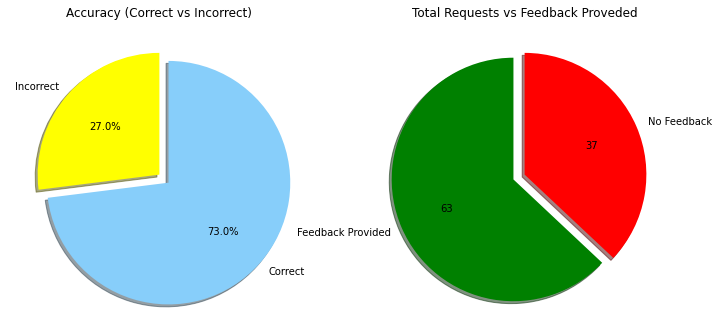

In [279]:
import numpy as np
import matplotlib.pyplot as plt

feedback_correct = feedback_metrics["aggregations"]["reward_sum"]["value"]
feedback_total = feedback_metrics["aggregations"]["reward_count"]["doc_count"]
feedback_incorrect = feedback_total - feedback_correct
no_feedback = es_count["count"] - feedback_total

plt.subplots(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Accuracy (Correct vs Incorrect)")
plt.pie([feedback_incorrect, feedback_correct], explode=(0, 0.1), labels=('Incorrect', 'Correct'), autopct='%1.1f%%', shadow=True, startangle=90, colors=['yellow', 'lightskyblue'])  

plt.subplot(1, 2, 2)
plt.title("Total Requests vs Feedback Proveded")
plt.pie([feedback_total, no_feedback], explode=(0.1, 0), labels=('Feedback Provided', 'No Feedback'), autopct='%.0f', shadow=True, startangle=90, colors=['green', 'red'])

plt.show()

## Real Time Metrics Example

Similar to the design pattern that Seldon Core introduced with request logging and outlier detectors through asynchronous eventing, it's possible to do the same for metrics.

More specifically, it is possible to set up a stateful feedback processor which retrieves all the metrics on start and registers for feedback events to provide real time insights on any new incoming requests.

In this notebook we show how this can be achieved thorugh two different approaches:
* As a separate stateful metrics processor using KNative Eventing
* Implemented in the seldon model itself

Below we dive into both examples together with tradeoffs.

#### Example of custom stateful metrics processor

These can then be visualised through different areas such as through prometheus metrics, using a grafana dashboard. Below is a brief example of how this can be achieved through a simple implementation.


<img src="img/custom-stateful.jpg">



First we deploy the Seldon Core Analyitcs

In [ ]:
!helm install seldon-core-analytics ../../../helm-charts/seldon-core-analytics --namespace seldon-system

Now we should be able to access the grafana dashboard for the model. You can access it by port-forwarding the grafana dashboard with:
```
kubectl port-forward -n seldon-system svc/seldon-core-analytics-grafana 7000:80
```
This way you can now access it via `http://localhost:7000` with the username `admin` and password `password`.

You should be able to see the following dashboard out of the box:
![](img/base-dashboard.jpg)

Now we can deploy our [stateful metrics component](../../../components/stateful-metrics-server/) with the following configuration:

In [ ]:
%%bash
kubectl apply -n seldon-logs -f - << END
---
apiVersion: apps/v1
kind: Deployment
metadata:
 name: seldon-stateful-metrics-sklearn-deployment
 labels:
   app: seldon-stateful-metrics-sklearn
spec:
 replicas: 1
 selector:
   matchLabels:
     app: seldon-stateful-metrics-sklearn
 template:
   metadata:
     annotations:
       prometheus.io/path: /metrics
       prometheus.io/scrape: "true"
     labels:
       app: seldon-stateful-metrics-sklearn
   spec:
     containers:
       - name: user-container
         image: docker.io/seldonio/stateful-metrics-server:1.2.2-dev
         imagePullPolicy: IfNotPresent
         ports:
         - containerPort: 8080
           name: metrics
           protocol: TCP
         - containerPort: 8080
           name: http
           protocol: TCP
         env:
           - name: ELASTICSEARCH_HOST
             value: "elasticsearch-master.seldon-logs.svc.cluster.local"
           - name: ELASTICSEARCH_PORT
             value: "9200"
---
apiVersion: v1
kind: Service
metadata:
 name: seldon-stateful-metrics-sklearn-svc
spec:
 selector:
   app: seldon-stateful-metrics-sklearn
 ports:
   - protocol: TCP
     port: 80
     targetPort: 8080
END

A couple of things to notice, is that here we have enabled prometheus scraping to the `/metrics` endpoint, and we've also added the named `metrcs` port, which `seldon-core-analytics` is configured to scrape from.

Now we can actually deploy the trigger for the model we've built:

In [ ]:
%%bash
kubectl apply -n seldon-logs -f - << END
apiVersion: eventing.knative.dev/v1alpha1
kind: Trigger
metadata:
  name: seldon-stateful-metrics-sklearn-trigger
spec:
  subscriber:
    ref:
      apiVersion: v1
      kind: Service
      name: seldon-stateful-metrics-sklearn-svc
  filter:
    attributes:
      type: io.seldon.serving.feedback
      inferenceservicename: sklearn
END

You can see that this trigger is filtering on the `type: io.seldon.serving.feedback` and `inferenceservicename: sklearn`.

Once we have this, we actually would see that it automatically collects all of the available logs and starts producing metrics that are being collected with prometheus.

We can confirm this by proceeding to our dashboard and adding a new dashboard, with the prometheus datasource, and the metric would have as value `sum(correct_total) / sum(total_total)` which basically is the metric `correct_total` divided by the `total_total` which shoudl give us the real time accuracy.

You should be able to see the following: 

![](img/accuracy-dashboard.jpg)

Once you add this dashboard, you can set it to refresh every 5 minutes, and in turn, we will now be able to see real time accuracy changing, let's actually start some data:

In [ ]:
import time
import random

CORRECT_PROBABILITY = 0.8

pred_req = {"data":{"ndarray":[[1,2,3,4]]}}
default_truth_val = {'data': { 'names': ['t:0', 't:1', 't:2'], 'ndarray': [[0, 0, 1]]}}
default_truth_meta = {"tags": {"user": "Seldon Admin", "date": "11/07/2020"}}

while True:
    pred_resp = requests.post(f"{url}/predictions", json=pred_req)
    assert pred_resp.status_code == 200
    idx = pred_resp.headers["seldon-puid"]
    time.sleep(0.1)
    
    pred = 1 if random.random() > CORRECT_PROBABILITY else 0
    print(f"Sending: {pred} ")
    feedback = {}
    feedback["reward"] = 1 if pred else 0
    feedback["truth"] = {} if pred else default_truth_val
    feedback["truth"]["meta"] = default_truth_meta
    feed_resp = requests.post(f"{url}/feedback", json=feedback, headers={"seldon-puid": sid})
    assert feed_resp.status_code == 200
    time.sleep(0.5)    

This will send requests that will show 80% probablility of incorrect predictions, showing a steady decline in accuracy as per the image below.

![](img/realtime-accuracy.jpg)

This could be quite powerful as it could be connected with something like Alertmanager to ensure alerts are sent if the model metric drops below a specific percentage.

If you wish to load the dashboard directly, you can also do this by importing the json below in your grafana dashboard:

In [ ]:
{"annotations": {"list": [{"builtIn": 1,"datasource": "-- Grafana --","enable": true,"hide": true,"iconColor": "rgba(0, 211, 255, 1)","name": "Annotations & Alerts","type": "dashboard"}]},"editable": true,"gnetId": null,"graphTooltip": 0,"id": null,"links": [],"panels": [{"aliasColors": {},"bars": true,"dashLength": 10,"dashes": false,"datasource": "prometheus","description": "","fieldConfig": {"defaults": {"custom": {}},"overrides": []},"fill": 1,"fillGradient": 0,"gridPos": {"h": 12,"w": 24,"x": 0,"y": 0},"hiddenSeries": false,"id": 2,"legend": {"avg": false,"current": false,"max": false,"min": false,"show": true,"total": false,"values": false},"lines": true,"linewidth": 1,"nullPointMode": "null","options": {"dataLinks": []},"percentage": false,"pointradius": 2,"points": false,"renderer": "flot","seriesOverrides": [],"spaceLength": 10,"stack": false,"steppedLine": false,"targets": [{"expr": "sum(correct_total) / sum(total_total)","interval": "","legendFormat": "Accuracy %","refId": "A"}],"thresholds": [],"timeFrom": null,"timeRegions": [],"timeShift": null,"title": "Real Time Model Accuracy","tooltip": {"shared": true,"sort": 0,"value_type": "individual"},"type": "graph","xaxis": {"buckets": null,"mode": "time","name": null,"show": true,"values": []},"yaxes": [{"decimals": null,"format": "short","label": null,"logBase": 1,"max": "1","min": "0","show": true},{"format": "short","label": null,"logBase": 1,"max": null,"min": null,"show": true}],"yaxis": {"align": false,"alignLevel": null}}],"refresh": "5s","schemaVersion": 25,"style": "dark","tags": [],"templating": {"list": []},"time": {"from": "now-5m","to": "now"},"timepicker": {"refresh_intervals": ["10s","30s","1m","5m","15m","30m","1h","2h","1d"]},"timezone": "","title": "New dashboard","uid": null,"version": 0}

### Example using python wrapper

For this second example we will show how we can implement the stateful metrics in the python wrapper itself.

The reason why this is possible, is because the metrics server above is actually implemented in a very similar way to the wrapper.

Because of this, it will be possible to just use the wrapper itself and enable for more complex functionality.

Not only it's possible to store the metrics, but given that the models are loaded, it's possible to perform complex comparisons in the model itself.

Let's have a look at an example with the iris classifier example.

We will deploy two models as shadows and compare them using statistical metrics.


<img src="img/standard-server.jpg">

#### Train models

We will create a language wrapper, and we will have two models that we want to compare.

The first model is a LogisticRegression model, and the second is a Perceptron model.

We will first set everyhthing up with the LogisticRegression model.

In [56]:
%%writefile requirements.txt
joblib==0.14.1
scikit-learn==0.20.3

Writing requirements.txt


We install the dependencies for the training and inference of the model

In [ ]:
!pip install -r requirememnts.txt

Now we can build the model wrapper which uses sklearn 

In [74]:
import joblib
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn import datasets

parameters = [
    {"clf": LogisticRegression(solver="liblinear", multi_class="ovr"), "name": "iris-lr.joblib"},
    {"clf": Perceptron(n_iter=40, eta0=0.1, random_state=0), "name": "iris-percept.joblib"}
]

def main():
    for param in parameters:
        clf = param["clf"]
        p = Pipeline([("clf", clf)])
        print("Training model...")
        p.fit(X, y)
        print("Model trained!")

        print(f"Saving model in {param['name']}")
        joblib.dump(p, param['name'])
        print("Model saved!")


if __name__ == "__main__":
    print("Loading iris data set...")
    iris = datasets.load_iris()
    X, y = iris.data, iris.target
    print("Dataset loaded!")

    main()

Loading iris data set...
Dataset loaded!
Training model...
Model trained!
Saving model in iris-lr.joblib
Model saved!
Training model...
Model trained!
Saving model in iris-percept.joblib
Model saved!


/home/alejandro/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


We can see both our logistic regression model and the perceptron models are available

In [90]:
!ls

IrisClassifier.py  README_files  iris-lr.joblib       train_iris.py
README.ipynb	   __pycache__	 iris-percept.joblib
README.md	   img		 requirements.txt


We can now create our simple wrapper. In this wrapper we will be exposing some of the key custom metrics

In [91]:
%%writefile IrisClassifier.py
import joblib

class IrisClassifier:

    def __init__(self, model_name="iris-lr.joblib"):
        self.scores = {"correct": 0, "incorrect": 0}
        self.model = joblib.load(model_name)

    def predict(self, X, features_names=None, meta=None):
        return self.model.predict(X)

    def send_feedback(self, features, feature_names, reward, truth, routing=""):
        predicted = self.predict(features)
        if int(predicted[0]) == int(truth[0]):
            self.scores["correct"] += 1
        else:
            self.scores["incorrect"] += 1
        return [] # Ignore return statement as its not used
        
    def metrics(self):
        return [
            {"type": "GAUGE", "key": "correct", "value": self.scores["correct"]},
            {"type": "GAUGE", "key": "incorrect", "value": self.scores["incorrect"]},
        ]

Overwriting IrisClassifier.py


Now we can build the image

In [92]:
!s2i build . seldonio/seldon-core-s2i-python37:1.2.2-dev iris_perf:0.1 \
        --env MODEL_NAME=IrisClassifier --env API_TYPE=REST --env SERVICE_TYPE=MODEL --env PERSISTENCE=0

---> Installing application source...
---> Installing dependencies ...
Looking in links: /whl
Created wheel for PTable: filename=PTable-0.9.2-cp37-none-any.whl size=22906 sha256=9b6965b595a29f2f93c8c3bbb06938e11ca7a969381dbdd23ebbb31707710ffa
Stored in directory: /root/.cache/pip/wheels/22/cc/2e/55980bfe86393df3e9896146a01f6802978d09d7ebcba5ea56
Successfully built PTable
created path: ./licenses/license_info.csv
created path: ./licenses/license.txt
Build completed successfully


Now we can deploy a simple model to initially visualise the custom metrics that are generated

In [85]:
%%bash
kubectl apply -n seldon -f - <<END
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: iris-perf
spec:
  name: iris-perf
  predictors:
  - componentSpecs:
    - spec:
        containers:
        - image: iris_perf:0.1
          imagePullPolicy: IfNotPresent
          name: classifier
    graph:
      children: []
      endpoint:
        type: REST
      parameters:
      - name: model_name
        type: STRING
        value: iris-lr.joblib
      name: classifier
      type: MODEL
    name: default
    replicas: 1
END

seldondeployment.machinelearning.seldon.io/iris-lr configured


In [88]:
!kubectl get pods -n seldon | grep iris-lr

iris-lr-default-0-classifier-b6cb8c496-n4m55   2/2     Running   0          62s


Now that we have deployed the model let's send a couple of requests so we can generate metrics, and we can create the dashboard.

In [94]:
import requests

url = "http://localhost:80/seldon/seldon/iris-perf/api/v1.0"

correct = {"reward": 0, "request": {"data": {"ndarray": [[1,2,3,4]]}}, "truth":{"data": {"ndarray": [[1]]}}}
incorrect = {"reward": 0, "request": {"data": {"ndarray": [[1,2,3,4]]}}, "truth":{"data": {"ndarray": [[2]]}}}

for i in range(7):
    requests.post(f"{url}/feedback", json=incorrect)
for i in range(93):
    requests.post(f"{url}/feedback", json=incorrect)

Now we can go to grafana and create a dashboard. We just need to go to the dashboard and provide the custom metrics to create the dashboard.

For this, we just have to select "prometheus" as the main source, and then we just have to add `sum(correct)/(sum(incorrect)+sum(correct))` as the equation.

We should then be able to see the following dashboard:

![](img/model-perf.jpg)

#### Compare two models performance
Now we can actually run two models in parallel and compare their performance against each other.

The previous model was trained with a LogisticRegrssion model, this one will be trained with a different SVM model

In [105]:
%%bash
kubectl apply -n seldon -f - <<END
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: iris-perf
spec:
  name: iris-perf
  predictors:
  - componentSpecs:
    - spec:
        containers:
        - image: iris_perf:0.1
          imagePullPolicy: IfNotPresent
          name: classifier
    graph:
      children: []
      endpoint:
        type: REST
      parameters:
      - name: model_name
        type: STRING
        value: iris-lr.joblib
      name: classifier
      type: MODEL
    name: default
    replicas: 1
  - componentSpecs:
    - spec:
        containers:
        - image: iris_perf:0.1
          imagePullPolicy: IfNotPresent
          name: classifier
    graph:
      children: []
      endpoint:
        type: REST
      parameters:
      - name: model_name
        type: STRING
        value: iris-percept.joblib
      name: classifier
      type: MODEL
    name: shadow
    replicas: 1
    shadow: true
END

seldondeployment.machinelearning.seldon.io/iris-perf created


We can now see that the logistic regression (default) and perceptron (shadow) models are running

In [113]:
!kubectl get pods -n seldon | grep iris

iris-perf-default-0-classifier-76998fb887-xjg79   2/2     Running   0          10m
iris-perf-shadow-0-classifier-7b4bffb85f-t68lw    2/2     Running   0          10m


We now just need to send some data. We can send the data one by one to simulate live data.

We will be able to see the data as it's computed in the dashboard

In [103]:
from sklearn import datasets

iris = datasets.load_iris()
X_in, y_in = iris.data, iris.target

In [111]:
import time

url = "http://localhost:80/seldon/seldon/iris-perf/api/v1.0"

for x, y in zip(X_in, y_in):
    data = {"reward": 0, "request": {"data": {"ndarray": [x.tolist()]}}, "truth":{"data": {"ndarray": [[y.tolist()]]}}}
    requests.post(f"{url}/feedback", json=data)
    time.sleep(0.1)

We can now see in real time the performance of both models in regards to accuracy.

We can see that our logistic regression model is performing better than our perceptron model.

In this case we would be able to programmatically promote the logistic regression model without loss of performance.

![](img/comparison.jpg)

As an extension, it's possible to easily implement further components including:
* Loading the historical feedback from elasticsearch upon starting (similar to the metrics server)
* Adding further statistical metrics (such as precision, recall, etc), and support multiclass metrics
* Storing feedback created by the python wrapper component

Based on this implementation, it seems that it's possible to:
* Explore providing out-of-the-box statistical metrics on accuracy
* Adding ability to amend feedback to provdie more advanced components to store in elasticsearch
* Provide out of the box means to load historical data for evaluation